In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
from model import VAE

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kiqmg8co because the default path (/home/mihalis/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [3]:
# Set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:
# Define data loading step

batch_size = 16

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
# Defining the device
model = VAE()

====> Test set loss: 95.2171
====> Epoch: 1 Average loss: 103.9243
====> Test set loss: 95.7445


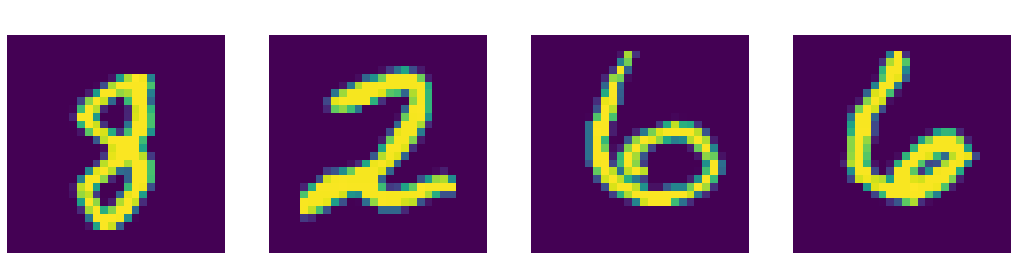

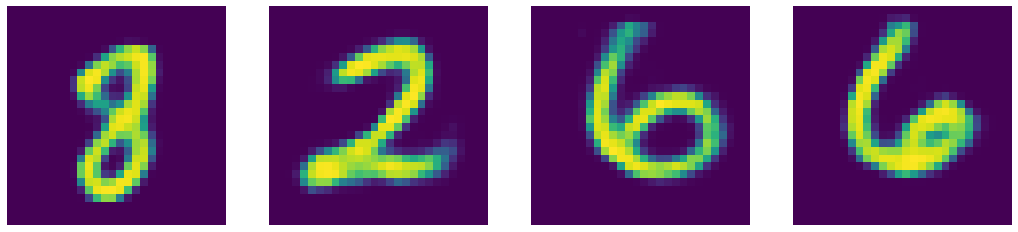

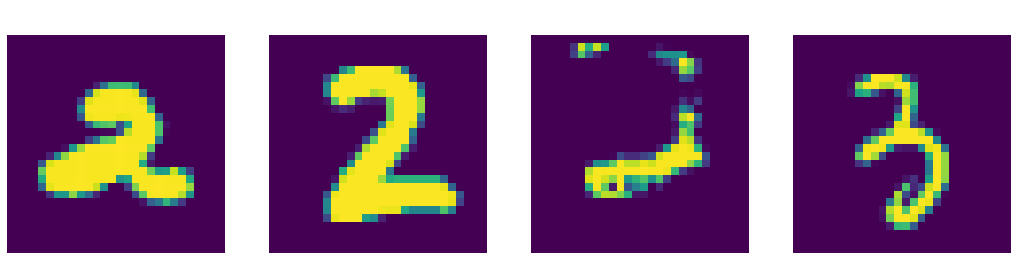

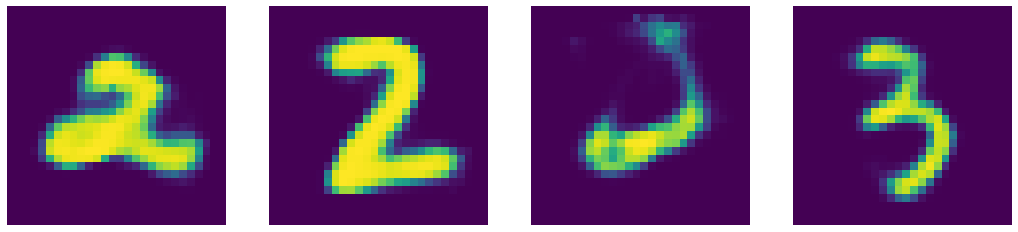

In [18]:
# Training and testing the VAE

epochs = 1
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            # ===================backward====================
            train_loss += model.backward(x_hat,x,mu,logvar)

        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += VAE.loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

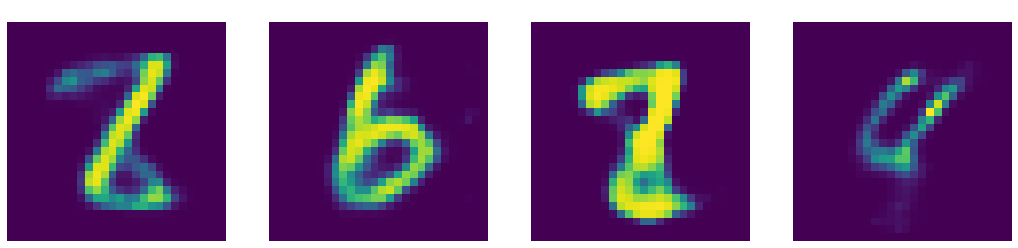

In [7]:
# Generating a few samples

N = 4
z = torch.randn((N, model.d))
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

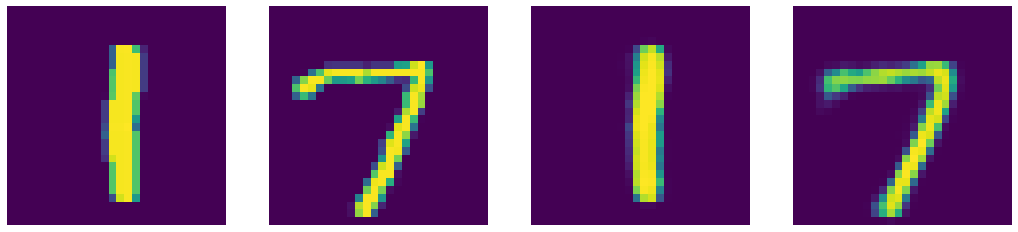

In [8]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 15
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

In [13]:
import numpy as np
from sklearn.manifold import TSNE

In [10]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 4)

In [16]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 20)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])

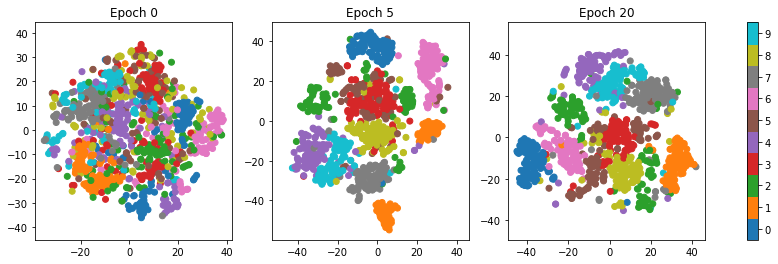

In [17]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)